# Select Textures

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn
from torchvision import transforms, datasets
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import util.util_validation as ut_val
from networks.resnet_big import SupCEResNet, SupConResNet, LinearClassifier, model_dict
from util.util_diff import DiffLoader, DiffTransform
from util.util_logging import open_csv_file

In [2]:
cuda_device = 0

dataset = "animals10_diff_-1"

# root_textures = "./datasets/adaIN/textures_animals10_two/"
root_textures = "./datasets/adaIN/textures_animals10_many/"
# root_textures = "./datasets/adaIN/experiments/textures_all/"
# root_textures = "./datasets/adaIN/experiments/texture_CE_and SupCon_baseline/"

## Sample some images from the Dataset

In [7]:
def create_files_dataFrame(root, classes):
    """
    Creates a pandas DataFrame for a image dataset of the form ./root/class/img.png

    Parameters
    ----------
    root: str
        The path to the dataset
    classes: iterable
        Containing the class names (folder names in the dataset)

    Returns
    ---------
    : pandas.DataFrame
    DataFrame with columns image for the file names of the images
    and label for the integer class label.
    """
    images = []
    labels = []
    for i, c in enumerate(classes):
        # get all image path for a class
        img_paths = glob.glob(os.path.join(root, f"{c}/*"))

        for img_path in img_paths:
            img_file = img_path.replace(os.path.join(root, f"{c}/"), '')
            images.append(img_file)
            labels.append(i)

    return pd.DataFrame.from_dict({'image': images, 'label': labels})

def plot_sample_images(dataset, img_class, use_training_data=False, root_dataset=None):
    image_loader = datasets.folder.default_loader
    classes = ut_val.get_classes(dataset)

    if use_training_data:
        root_train, _ = ut_val.get_root_dataset(dataset)
        
        df_train = create_files_dataFrame(root_train, classes)

        sample_images = df_train[df_train.label == np.where(np.array(classes) == img_class)[0][0]].sample(10)['image'].values
    else:
        _, root_test = ut_val.get_root_dataset(dataset)
        
        df_test = create_files_dataFrame(root_test, classes)

        sample_images = df_test[df_test.label == np.where(np.array(classes) == img_class)[0][0]].sample(10)['image'].values

    seaborn.set_theme(style="white")
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,20))
    fig.tight_layout()

    for i, img_path in enumerate(sample_images):
        img_tile = f"{i}"
        
        if root_dataset is not None:
            img = image_loader(os.path.join(root_dataset, img_class, img_path))
            img_tile += f" {img.size}"
        elif use_training_data:
            img = image_loader(os.path.join(root_train, img_class, img_path))
        else:
            img = image_loader(os.path.join(root_test, img_class, img_path))

        print(f"{img_tile}: {sample_images[i]}")
        axs[i%5,i//5].imshow(img)
        axs[i%5,i//5].set_title(img_tile)

In [8]:
print(ut_val.get_classes(dataset))

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


0 (300, 169): OIP-EPGkcmA4rwC2upPpDyAV5wHaEK.jpeg
1 (300, 169): OIP-BHXSG80l0UZv3vMiYKI0GAHaEK.jpeg
2 (300, 217): OIP-49EzwfQF4PfsCfNjoR4WMAHaFW.jpeg
3 (300, 225): OIP-2NZHqlDoyEwzU0XAcZfIGwHaFi.jpeg
4 (293, 300): OIP-D1uFxT3QcS914s9UvFTXTwHaHm.jpeg
5 (300, 169): OIP-Vh1y7B4fKjKT6keqByhmnwHaEK.jpeg
6 (300, 169): OIP-gFAHs1pxjTil2gj_xJbk5AHaEK.jpeg
7 (203, 300): OIP-hny39QRxZarUqepFK-PVnwHaK_.jpeg
8 (300, 225): OIP-TAMg8unY8r7Dti07s481UwHaFj.jpeg
9 (300, 300): OIP-lcrEGd7DDvuGE37URIXssQHaHa.jpeg


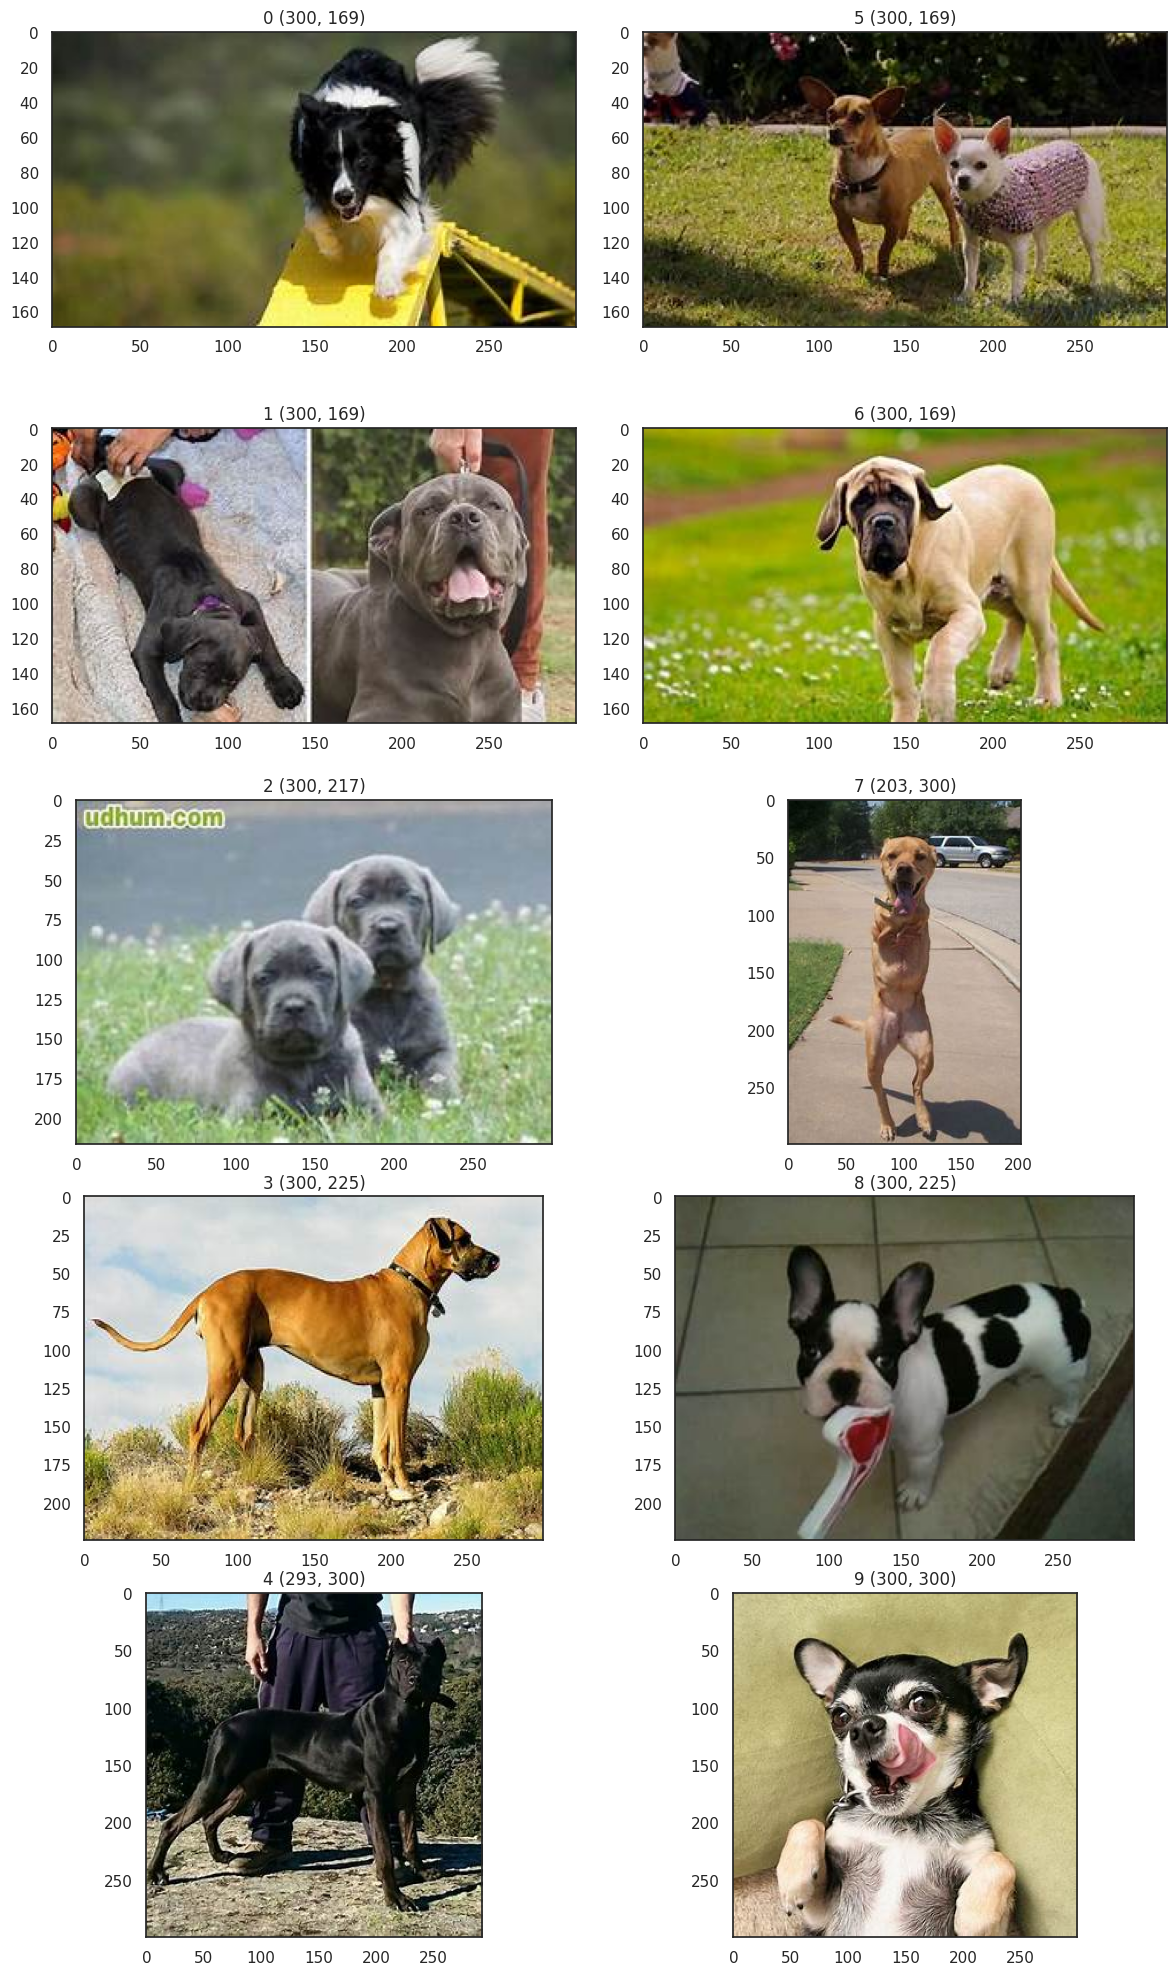

In [20]:
plot_sample_images(dataset=dataset, img_class="cane", use_training_data=True, root_dataset="./datasets/animals10/raw-img/")

## Look at the predictions of the Textures

In [4]:
class TextureLoader:
    def __init__(self, path_texture:str, path_orig:str, loader=datasets.folder.default_loader):
        self.path_texture = path_texture
        self.path_orig = path_orig
        self.loader = loader

    def __call__(self, path:str):
        ending = '.' + path.split('.')[-1]
        orig_path = path.replace(ending, '').replace(self.path_texture, self.path_orig)
        orig_path = glob.glob(orig_path + ".*")[0]
        return [self.loader(path), self.loader(orig_path)]

def evaluate_textures(root_model, root_textures, dataset, dataset_classifier, cuda_device):
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    _, root_test = ut_val.get_root_dataset(dataset)
    classes = ut_val.get_classes(dataset)

    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
    texture_transform = transforms.Compose([transforms.Resize(params['size']), transforms.CenterCrop(params['size']), transforms.ToTensor(), normalize])
    texture_dataset = datasets.ImageFolder(root=root_textures,
                                           loader=TextureLoader(path_texture=root_textures, path_orig=root_test),
                                           transform=DiffTransform(texture_transform))
    texture_dataloader = torch.utils.data.DataLoader(texture_dataset, batch_size=params['batch_size'],
                                                     shuffle=False, num_workers=8, pin_memory=True)

    model = ut_val.set_model(root_model, params, cuda_device)

    if 'method' in params:
        path_classifier = ut_val.get_path_classifier(root_model, dataset_classifier, params)
        classifier = ut_val.load_classifier_checkpoint(path_classifier, params["model"], len(classes), cuda_device)
    else:
        classifier = model.fc

    model.eval()
    classifier.eval()

    true_classes = []
    pred_classes = []
    pred_orig_classes = []

    for images, labels in texture_dataloader:
        texture, original = images
        texture = texture.cuda(device=cuda_device, non_blocking=True)
        original = original.cuda(device=cuda_device, non_blocking=True)

        with torch.no_grad():
            # texture
            features = model.encoder(texture)
            output = classifier(features)
            _, pred = output.topk(1, 1, True, True)
            # original
            features_orig = model.encoder(original)
            output_orig = classifier(features_orig)
            _, pred_orig = output_orig.topk(1, 1, True, True)

        true_classes.extend(labels.numpy())
        pred_classes.extend(pred.cpu().numpy().reshape(-1))
        pred_orig_classes.extend(pred_orig.cpu().numpy().reshape(-1))


    texture_paths = [t_path for t_path, _ in texture_dataset.samples]
    df_pred = pd.DataFrame.from_dict({"true_class": true_classes, "pred_class": pred_classes, "pred_orig_class": pred_orig_classes, "texture_path": texture_paths})

    C = ut_val.get_confusion_matrix(df_pred)
    acc, acc_b = ut_val.compute_accuracies(C)
    print(f"Textures: acc: {acc*100:.3f}, acc_b: {acc_b*100:.3f}")

    C_orig = ut_val.get_confusion_matrix(df_pred, pred="pred_orig_class")
    acc_orig, acc_orig_b = ut_val.compute_accuracies(C_orig)
    print(f"Originals: acc: {acc_orig*100:.3f}, acc_b: {acc_orig_b*100:.3f}")

    seaborn.set_theme(style="ticks")

    fig, axs = plt.subplots(ncols=2, figsize=(11,5))
    fig.tight_layout(w_pad=4)

    disp = ConfusionMatrixDisplay(C, display_labels=classes)
    disp.plot(xticks_rotation=45, ax=axs[0])
    for labels in disp.text_.ravel():
        labels.set_fontsize(10)

    disp_orig = ConfusionMatrixDisplay(C_orig, display_labels=classes)
    disp_orig.plot(xticks_rotation=45, ax=axs[1])
    for labels in disp_orig.text_.ravel():
        labels.set_fontsize(10)

    return df_pred

### CE_baseline

Textures: acc: 48.444, acc_b: 49.978
Originals: acc: 97.778, acc_b: 98.074


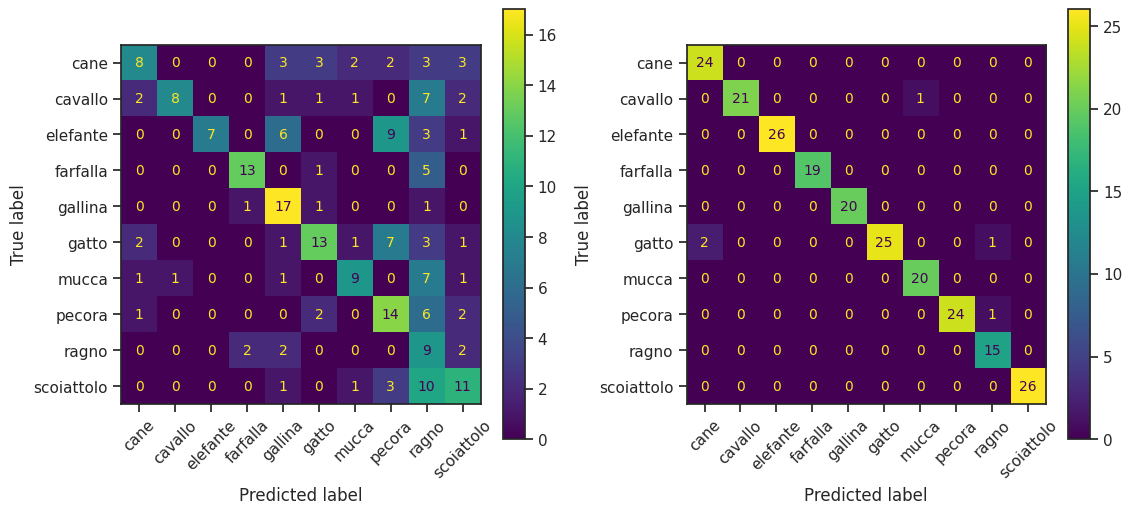

In [5]:
root_model = "./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_baseline_cosine/models/last.pth"
dataset_classifier = ""
df_pred_CE = evaluate_textures(root_model=root_model, root_textures=root_textures, dataset=dataset, dataset_classifier=dataset_classifier, cuda_device=cuda_device)

### SupCon_baseline

Textures: acc: 36.889, acc_b: 38.909
Originals: acc: 97.778, acc_b: 98.015


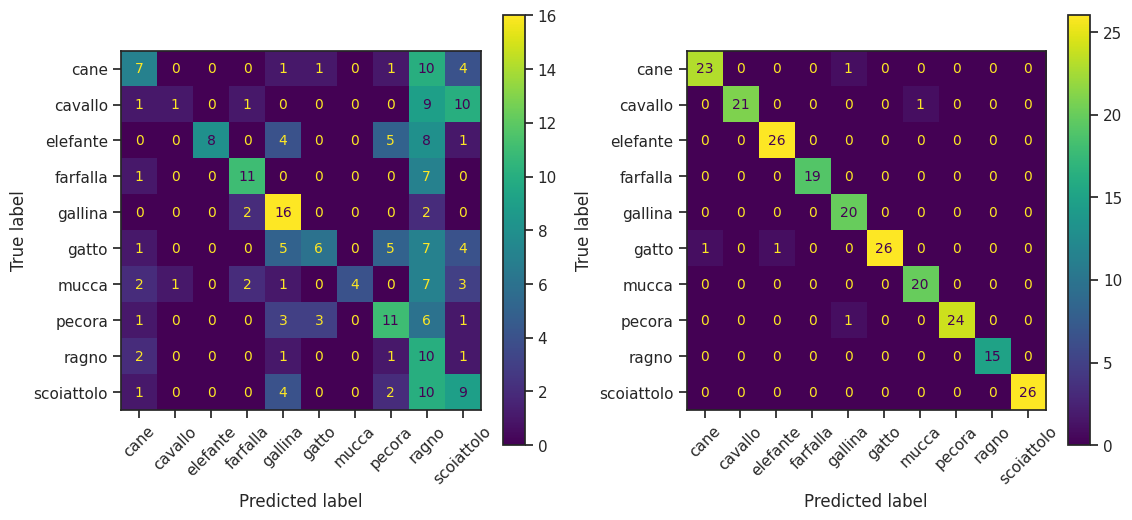

In [6]:
root_model = "./save/SupCon/animals10_diff_-1/SupCon_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_try3_cosine/models/last.pth"
dataset_classifier = ""
df_pred_supCon = evaluate_textures(root_model=root_model, root_textures=root_textures, dataset=dataset, dataset_classifier=dataset_classifier, cuda_device=cuda_device)